In the first question, I have suggested that we don't really know the number of clusters as increasing K caused more clusters. In this question, I seek answer to how many clusters are there given the data and its properties. 

In [1]:
from __future__ import (absolute_import, print_function, division)
import numba #jit to make code faster
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
import os
from scipy.stats import dirichlet
import numpy as np
import scipy
from np.random import normal as rnorm
from numpy import diag
from numpy import trace as tr
from numpy.random import random as rand
from numpy.linalg import inv
from scipy.stats import multivariate_normal.pdf as mvarnorm
from scipy.stats import multivariate_normal as mvn
from scipy import stats
from scipy.stats import wishart
from scipy.stats import norm
from stats.dirichlet import entropy as direntropy
from numpy.linalg import inv
from numpy import log as ln
from scipy.special import psi
from numpy.linalg import det
from np import log as ln
from scipy.special import psi
from scipy.special import gammaln



%matplotlib inline


wpdf = wishart.pdf
dirpdf = dirichlet.pdf
discrete = rv_discrete

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


Mixture model used to generate data:

* Model: $c_i ≈ Discrete(\pi)$, $x_i ≈ p(x|\theta_{c_i})$

* Priors: $\pi ≈ Dirichlet( \alpha, \alpha, ..., \alpha)$, $\theta_j ≈ p(\theta)$

Gaussian Mixture Model:
$\theta_j = \{ \mu_j, \Lambda_j\}$

$p(x|\theta_j) = Normal(\mu_j, \Lambda_j^{-1})$ and $p(\theta) = Normal-Wishart

**The Dirichlet process "uncovers" the correct number of clusters. Marginalization of $\pi$ will save the day in Gibbs sampling setup.**

Overall Gibbs Sampling Procedure
-----
1. For each iteration:

    a. Sample each $c_i$ given the most recent $\pi, \theta, and\ other\ c_{-i}$
    
    b. Sample each $\theta_i$ given the most recent c, $\pi$, and $\theta_{-i}$ 
    
    c. Sample $\pi$ given the most recent c and $\theta$
    
**note**: just like the earlier model in problem 2, j is iteration count over k.


**Sampling $c_i$:**
* $p(c_i = j | X, \theta, c_{-i}) p(c_i=j|c)$ 
$p(c_i = j | X, \theta, c_{-i})$ is multivariate-normal on $\mu_j$ and $\Lambda_j$

In [2]:
def sample_c_i(mu_j, lambda_j, xi, alpha, n, c_i):
    """Indicates how likely each cluster is for the data point in x_i and pre-weight.
    Returns
    ------
    A normalized K dimensional vector. This is to be used as parameter of Discrete distro 
    to sample a new index value for c_i.    
    """
    x_given_theta = mvn.pdf(xi, mu_j[j], inv(lambda_j[j])) 
    
    
def sample_theta_j(x):
    """Only depends ont he data in x_train that is assigned to cluster j. Calculate posterior in closed form
    and sample from it.
    """
    pass


def sample_pi(c):
    """ Simple Dirichlet prior-multinomial likelihood setting. Conditional posterior of pi only depends on c.
    """
    pass

mvnorm = scipy.stats.multivariate_normal.pdf
inv = np.linalg.inv 
mvnorm_sample = stats.multivariate_normal.rvs
wishart_sample = stats.wishart.rvs
dirichlet_sample= stats.dirichlet.rvs

_I noticed that we did not really have to calculate these variables for finite K as we assume via Gibbs sampling that these terms will be marginalized using the limits.  Instead, I simplified the problem by using the appropriate algorithm for Dirichlet Process Gaussian Mixture model. I left the above as a mental guideline for myself to keep track of where things come from._

In [7]:
# @numba.jit
def calc_posterior(xtrn, a, B, c, m):
    s, d= xtrn.shape
    xbar = np.mean(xtrn,0)
    sum_xbarxT = 0
    for xi in xtrn.values:
        xminusxbar = (xi-xbar).reshape(d,1)
        sum_xbarxT+= xminusxbar.dot(xminusxbar.T)
    xmxbar = (xbar-m).dot((xbar-m).T)
    m_j = (c/(s+c))*m+ (1/(s+c))*np.sum(xtrn,axis=0)
    c_j = s + c 
    a_j = s + a
    B_j = B + sum_xbarxT+ (s/(a*s+1.0))*xmxbar
    my_lambda = wishart_sampler(a_j,inv(B_j))
    mu =mvnorm_sampler(mean=m_j,cov=inv(c_j*my_lambda))
    return mu, my_lambda

def gibbs(xtrn,T):
    n,d = xtrn.shape
    alpha_k = 1.0
    c_i = np.zeros(n)
    phi_ij = np.zeros((n,n))
    phi_ij[:,0]=1.0
    c = (0.1)
    a = float(d)
    B = c * float(d)* (np.cov(xtrn.T))
    m =np.mean(xtrn,axis=0)
    mu = [np.zeros(n) for i in range(n)]
    my_lambda = [np.zeros((n,n)) for i in range(n)]
    mu[0], my_lambda[0] = calc_posterior(xtrn,a,B,c,m)
    observation_ct = range(T)
    for t in range(T):
        phi_ij = np.zeros((n,n))
        for i, xi in enumerate(xtrn.values):
            tmpn=np.asarray([len(np.where(c_i==z)[0]) 
                             if z!=c_i[i] 
                             else len(np.where(c_i==z)[0])-1 
                             for z in range(n)])
            n_j=np.where(tmpn>0)[0]
            for j in n_j:
                phi_ij[i,j] = mvnorm(xi,mu[j],inv(my_lambda[j])) * tmpn[j]/(alpha_k+n-1)
            jprime=int(max(set(c_i))+1)
            xm = (xi-m.reshape((1,d))).reshape((d,1))
            tmp= xm.dot(xm.T)
            t1 = (c/(pi*(1.0+c)) )**(d/2)  
            t2 = det(B+ (c/(1.0+c))*tmp )**(-(a+1.0)/2.0) / det(B)**(-a/2.0)
            t3 = np.exp(np.sum([gammaln((a+1.0)/2.0- float(j)/2.0 )-gammaln(a/2.0-float(j)/2.0) for j in range(int(d))]))
            p_xi = t3 * t2 * t1
            phi_ij[i,jprime] = alpha_k / (alpha_k + n - 1) * p_xi
            phi_ij[i] = phi_ij[i] / np.sum(phi_ij[i])
            idx = np.where(phi_ij[i])[0]
            dirch_sampler = dirichlet_sampler(phi_ij[i][phi_ij[i]>0])
            c_i[i] = idx[np.argmax(dirch_sampler)]
            if c_i[i]==jprime:
                mu[jprime], my_lambda[jprime] = calc_posterior(xtrn[c_i==jprime],a,B,c,m)
        for k in set(c_i):
            mu[int(k)], my_lambda[int(k)] = calc_posterior(xtrn[c_i==k],a,B,c,m)
        observation_ct[t] = [np.sum(c_i==i) for i in set(c_i)]
    for t in observation_ct:
        t.sort(reverse=True)
    return my_lambda,observation_ct,c_i, phi_ij, mu,

In [22]:
def plot_cluster_vs_iter(count):
    maximum_value =[]
    for i in count:
        maximum_value= max(np.max(len(i)),maximum_value)
    output = np.zeros((len(count),maximum_value))
    for i,clusters_n in enumerate(count):
        for j, cluster_id in enumerate(clusters_n):
            output[i,j] = cluster_id
    plt.figure(figsize=(14,14))
    plt.plot(output)
    plt.title('Number of Observations/Cluster vs Iter Count- Part b')
    plt.xlabel('Iteration Count')    
    plt.ylabel('Number of Observations/cluster')
    plt.show()
    
def plot_TotalClusters(count):
    output= [len(i) for i in count]
    plt.figure(figsize=(14,14))
    plt.plot(output)
    plt.title('Total Number of Clusters that contain data- Part c')
    plt.xlabel('Iteration Count')    
    plt.ylabel('Total Number of clusters')
    plt.show()

In [9]:
os.chdir('/Users/arkilic/Desktop/')
xtrn =pd.read_csv('data.txt',header=None)

In [15]:
gibbgmm = gibbs(xtrn,500)

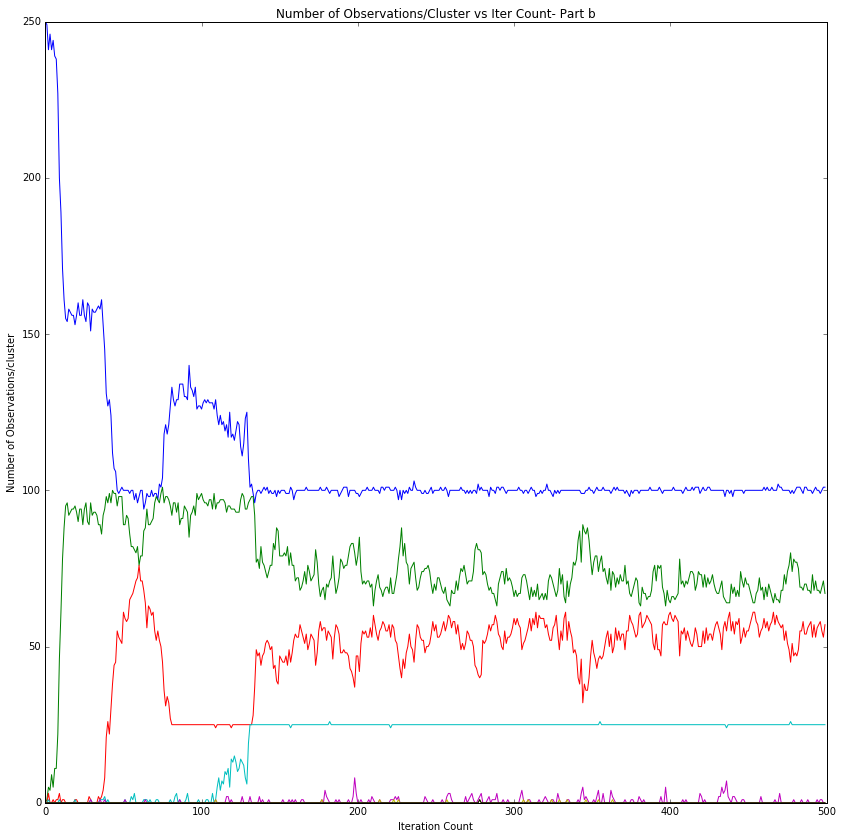

In [23]:
plot_cluster_vs_iter(gibbgmm[4])

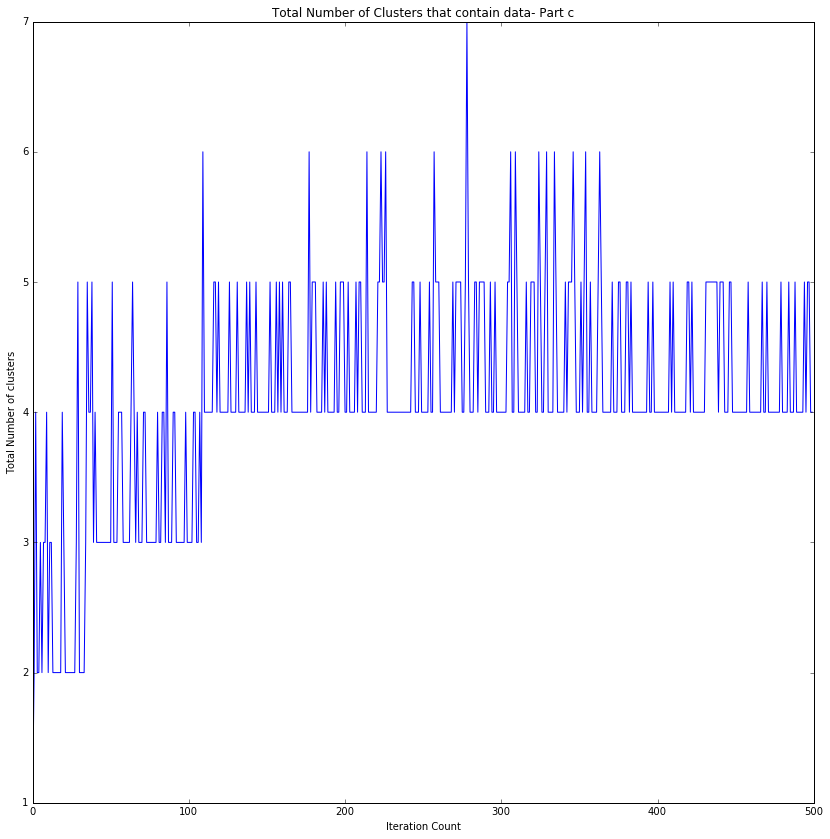

In [24]:
plot_TotalClusters(gibbgmm[4])

_As you can see in the images above, the total number of clusters (k) given iteration count fluctutates quite a bit. Again, this is due to the nature of Gibbs sampling on Gaussian Mixture models. In comparison to the first question where there was no clear indication on what K should be (well this fluctutaion was not obvious), we can get some visual hint regarding what sort of K we should be picking. As a pretty hands on guy who happens to write tons of data analysis code, I appreciate this sort of selection method for K as K significantly affects the time it takes code to run and quality of the output. I understand and appreciate how these 3 questions built up to this point, eliminated some ambiguity I had understanding this material._